In [1]:
# Importing libraries and setting up the environment
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.colors as mcolors
from scipy.interpolate import griddata
from statsmodels.genmod.families import Binomial
from mpl_toolkits.basemap import Basemap
import matplotlib.ticker as plticker
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
from scipy.stats import ttest_rel
from scipy.interpolate import Rbf
import numpy as np

warnings.filterwarnings("ignore")  # setting ignore as a parameter
image_format = "svg"  # setting image format as svg

In [2]:
# Import End of Century Land Cover Data
end_of_century_land_cover = pd.read_csv(
    "../data/agg_models_landcover.csv", names=["LON", "LAT", "POTVEG"]
)
end_of_century_land_cover = end_of_century_land_cover.drop_duplicates()
end_of_century_land_cover = end_of_century_land_cover.query(
    "POTVEG != 13 and POTVEG !=15"
)


# Function to read in data
def process_data(filepath, year):
    variable_data = pd.read_csv(
        filepath,
        names=[
            "LON",
            "LAT",
            "TMPVARNAME",
            "ICOHORT",
            "STANDAGE",
            "POTVEG",
            "CURRENTVEG",
            "SUBTYPE",
            "CMNT",
            "PSIPLUSC",
            "QLCON",
            "CAREA",
            "SUBAREA",
            "YEAR",
            "TOTAL",
            "MAX",
            "AVE",
            "MIN",
            "JAN",
            "FEB",
            "MAR",
            "APR",
            "MAY",
            "JUN",
            "JUL",
            "AUG",
            "SEP",
            "OCT",
            "NOV",
            "DEC",
            "REGION",
        ],
    )

    variable_data = variable_data.query(f"YEAR >= {year}")
    variable_data = variable_data.merge(
        end_of_century_land_cover, on=["LAT", "LON", "POTVEG"]
    )

    variable_data = variable_data.drop(
        columns=[
            "TMPVARNAME",
            "POTVEG",
            "ICOHORT",
            "STANDAGE",
            "CURRENTVEG",
            "SUBTYPE",
            "CMNT",
            "PSIPLUSC",
            "QLCON",
            "CAREA",
            "SUBAREA",
            "TOTAL",
            "MAX",
            # "AVE",
            "MIN",
            "JAN",
            "FEB",
            "MAR",
            "APR",
            "MAY",
            "JUN",
            "JUL",
            "AUG",
            "SEP",
            "OCT",
            "NOV",
            "DEC",
            "REGION",
        ]
    )

    variable_data = (
        variable_data.groupby(["LON", "LAT", "YEAR"]).agg({"AVE": "mean"}).reset_index()
    )
    return variable_data


# Define shared paths
shared_root_path = (
    "C:/Users/jmkod/OneDrive/Desktop/Lehigh University/Research/Data/tem/processing/"
)
npp_data_shared_path = "/data/output_bakeoff/npp_bakeoff_result.csv"
vegc_data_shared_path = "/data/output_bakeoff/vegc_bakeoff_result.csv"
nep_data_shared_path = "/data/output_bakeoff/nep_bakeoff_result.csv"
availn_data_shared_path = "/data/output_bakeoff/availn_bakeoff_result.csv"
gpp_data_shared_path = "/data/output_bakeoff/gpp_bakeoff_result.csv"
h2oyield_data_shared_path = "/data/output_bakeoff/h2oyield_bakeoff_result.csv"
netnmin_data_shared_path = "/data/output_bakeoff/netnmin_bakeoff_result.csv"
soilorgc_data_shared_path = "/data/output_bakeoff/soilorgc_bakeoff_result.csv"
veginnpp_data_shared_path = "/data/output_bakeoff/veginnpp_bakeoff_result.csv"
nce_data_shared_path = "/data/output_bakeoff/nce_bakeoff_result.csv"


# Aggregate Future Models Return 1 Dataframe
def aggregate_data(variable_models):
    future_variable = pd.concat(variable_models)
    future_variable = (
        future_variable.groupby(["LON", "LAT", "YEAR"])
        .agg({"AVE": "mean"})
        .reset_index()
        .round(2)
    )
    return future_variable


# Function to merge historical and future models on LON, LAT, group by LON, LAT,
# and calculate the mean of the historical and future models in each grid, then calculate the % difference between the two time periods,
# perform a t-test on each grid to test if the change is significant, and if the p-value is less than 0.05, change pvalue to 1, otherwise leaave blank


def calculate_difference(historical_model, future_models):
    merged = pd.merge(
        historical_model,
        future_models,
        on=["LON", "LAT"],
        suffixes=["_HISTORICAL", "_FUTURE"],
    )

    gridded = (
        merged.groupby(["LON", "LAT"])
        .agg({"AVE_HISTORICAL": "mean", "AVE_FUTURE": "mean"})
        .reset_index()
    )

    # Calculate the difference between the historical and future models
    gridded["DIFFERENCE"] = gridded["AVE_FUTURE"] - gridded["AVE_HISTORICAL"]

    # Calculate the percent difference between the historical and future models
    gridded["PERCENT_DIFFERENCE"] = (
        (gridded["AVE_FUTURE"] - gridded["AVE_HISTORICAL"])
        / gridded["AVE_HISTORICAL"]
        * 100
    )

    gridded["t_statistic"], gridded["p_value"] = ttest_rel(
        gridded["AVE_HISTORICAL"], gridded["AVE_FUTURE"]
    )
    gridded["p_value"] = gridded["p_value"].apply(lambda x: 1 if x < 0.05 else 0)

    return gridded

In [3]:
# Import Data


# Australia
vegc_model_1 = process_data(
    shared_root_path + "australia" + vegc_data_shared_path, 2069
)  # VEGC
npp_model_1 = process_data(
    shared_root_path + "australia" + npp_data_shared_path, 2069
)  # NPP
nep_model_1 = process_data(
    shared_root_path + "australia" + nep_data_shared_path, 2069
)  #
availn_model_1 = process_data(
    shared_root_path + "australia" + availn_data_shared_path, 2069
)  # AVAILN
gpp_model_1 = process_data(
    shared_root_path + "australia" + gpp_data_shared_path, 2069
)  # GPP
h2o_model_1 = process_data(
    shared_root_path + "australia" + h2oyield_data_shared_path, 2069
)  # H2OYIELD
netnmin_model_1 = process_data(
    shared_root_path + "australia" + netnmin_data_shared_path, 2069
)  # NETNMIN

soilorgc_model_1 = process_data(
    shared_root_path + "australia" + soilorgc_data_shared_path, 2069
)  # SOILORGC
veginnpp_model_1 = process_data(
    shared_root_path + "australia" + veginnpp_data_shared_path, 2069
)  # VEGINNPP
nce_model_1 = process_data(shared_root_path + "australia" + nce_data_shared_path, 2069)  # NCE

# Canada
vegc_model_2 = process_data(
    shared_root_path + "canada" + vegc_data_shared_path, 2069
)  # VEGC
npp_model_2 = process_data(
    shared_root_path + "canada" + npp_data_shared_path, 2069
)  # NPP
nep_model_2 = process_data(
    shared_root_path + "canada" + nep_data_shared_path, 2069
)  # NEP
availn_model_2 = process_data(
    shared_root_path + "canada" + availn_data_shared_path, 2069
)  # AVAILN
gpp_model_2 = process_data(
    shared_root_path + "canada" + gpp_data_shared_path, 2069
)  # GPP
h2o_model_2 = process_data(
    shared_root_path + "canada" + h2oyield_data_shared_path, 2069
)  # H2OYIELD
netnmin_model_2 = process_data(
    shared_root_path + "canada" + netnmin_data_shared_path, 2069
)  # NETNMIN

soilorgc_model_2 = process_data(
    shared_root_path + "canada" + soilorgc_data_shared_path, 2069
)  # SOILORGC
veginnpp_model_2 = process_data(
    shared_root_path + "canada" + veginnpp_data_shared_path, 2069
)  # VEGINNPP

nce_model_2 = process_data(shared_root_path + "canada" + nce_data_shared_path, 2069)  # NCE

# China
vegc_model_3 = process_data(
    shared_root_path + "china" + vegc_data_shared_path, 2069
)  # VEGC
npp_model_3 = process_data(
    shared_root_path + "china" + npp_data_shared_path, 2069
)  # NPP
nep_model_3 = process_data(
    shared_root_path + "china" + nep_data_shared_path, 2069
)  # NEP
availn_model_3 = process_data(
    shared_root_path + "china" + availn_data_shared_path, 2069
)  # AVAILN
gpp_model_3 = process_data(
    shared_root_path + "china" + gpp_data_shared_path, 2069
)  # GPP
h2o_model_3 = process_data(
    shared_root_path + "china" + h2oyield_data_shared_path, 2069
)  # H2OYIELD
netnmin_model_3 = process_data(
    shared_root_path + "china" + netnmin_data_shared_path, 2069
)  # NETNMIN

soilorgc_model_3 = process_data(
    shared_root_path + "china" + soilorgc_data_shared_path, 2069
)  # SOILORGC
veginnpp_model_3 = process_data(
    shared_root_path + "china" + veginnpp_data_shared_path, 2069
)  # VEGINNPP

nce_model_3 = process_data(shared_root_path + "china" + nce_data_shared_path, 2069)  # NCE
# France
vegc_model_4 = process_data(
    shared_root_path + "france" + vegc_data_shared_path, 2069
)  # VEGC
npp_model_4 = process_data(
    shared_root_path + "france" + npp_data_shared_path, 2069
)  # NPP
nep_model_4 = process_data(
    shared_root_path + "france" + nep_data_shared_path, 2069
)  # NEP
availn_model_4 = process_data(
    shared_root_path + "france" + availn_data_shared_path, 2069
)  # AVAILN
gpp_model_4 = process_data(
    shared_root_path + "france" + gpp_data_shared_path, 2069
)  # GPP
h2o_model_4 = process_data(
    shared_root_path + "france" + h2oyield_data_shared_path, 2069
)  # H2OYIELD
netnmin_model_4 = process_data(
    shared_root_path + "france" + netnmin_data_shared_path, 2069
)  # NETNMIN

soilorgc_model_4 = process_data(
    shared_root_path + "france" + soilorgc_data_shared_path, 2069
)  # SOILORGC
veginnpp_model_4 = process_data(
    shared_root_path + "france" + veginnpp_data_shared_path, 2069
)  # VEGINNPP

nce_model_4 = process_data(shared_root_path + "france" + nce_data_shared_path, 2069)  # NCE

# Japan
vegc_model_5 = process_data(
    shared_root_path + "japan" + vegc_data_shared_path, 2069
)  # VEGC
npp_model_5 = process_data(
    shared_root_path + "japan" + npp_data_shared_path, 2069
)  # NPP
nep_model_5 = process_data(
    shared_root_path + "japan" + nep_data_shared_path, 2069
)  # NEP
availn_model_5 = process_data(
    shared_root_path + "japan" + availn_data_shared_path, 2069
)  # AVAILN
gpp_model_5 = process_data(
    shared_root_path + "japan" + gpp_data_shared_path, 2069
)  # GPP
h2o_model_5 = process_data(
    shared_root_path + "japan" + h2oyield_data_shared_path, 2069
)  # H2OYIELD
netnmin_model_5 = process_data(
    shared_root_path + "japan" + netnmin_data_shared_path, 2069
)  # NETNMIN

soilorgc_model_5 = process_data(
    shared_root_path + "japan" + soilorgc_data_shared_path, 2069
)  # SOILORGC
veginnpp_model_5 = process_data(
    shared_root_path + "japan" + veginnpp_data_shared_path, 2069
)  # VEGINNPP

nce_model_5 = process_data(shared_root_path + "japan" + nce_data_shared_path, 2069)  # NCE

# Norway
vegc_model_6 = process_data(
    shared_root_path + "norway" + vegc_data_shared_path, 2069
)  # VEGC
npp_model_6 = process_data(
    shared_root_path + "norway" + npp_data_shared_path, 2069
)  # NPP
nep_model_6 = process_data(
    shared_root_path + "norway" + nep_data_shared_path, 2069
)  # NEP
availn_model_6 = process_data(
    shared_root_path + "norway" + availn_data_shared_path, 2069
)  # AVAILN
gpp_model_6 = process_data(
    shared_root_path + "norway" + gpp_data_shared_path, 2069
)  # GPP
h2o_model_6 = process_data(
    shared_root_path + "norway" + h2oyield_data_shared_path, 2069
)  # H2OYIELD
netnmin_model_6 = process_data(
    shared_root_path + "norway" + netnmin_data_shared_path, 2069
)  # NETNMIN

soilorgc_model_6 = process_data(
    shared_root_path + "norway" + soilorgc_data_shared_path, 2069
)  # SOILORGC
veginnpp_model_6 = process_data(
    shared_root_path + "norway" + veginnpp_data_shared_path, 2069
)  # VEGINNPP

nce_model_6 = process_data(shared_root_path + "norway" + nce_data_shared_path, 2069)  # NCE

# United Kingdom
vegc_model_7 = process_data(
    shared_root_path + "united_kingdom" + vegc_data_shared_path, 2069
)  # VEGC
npp_model_7 = process_data(
    shared_root_path + "united_kingdom" + npp_data_shared_path, 2069
)  # NPP
nep_model_7 = process_data(
    shared_root_path + "united_kingdom" + nep_data_shared_path, 2069
)  # NEP
availn_model_7 = process_data(
    shared_root_path + "united_kingdom" + availn_data_shared_path, 2069
)  # AVAILN
gpp_model_7 = process_data(
    shared_root_path + "united_kingdom" + gpp_data_shared_path, 2069
)  # GPP
h2o_model_7 = process_data(
    shared_root_path + "united_kingdom" + h2oyield_data_shared_path, 2069
)  # H2OYIELD
netnmin_model_7 = process_data(
    shared_root_path + "united_kingdom" + netnmin_data_shared_path, 2069
)  # NETNMIN

soilorgc_model_7 = process_data(
    shared_root_path + "united_kingdom" + soilorgc_data_shared_path, 2069
)  # SOILORGC
veginnpp_model_7 = process_data(
    shared_root_path + "united_kingdom" + veginnpp_data_shared_path, 2069
)  # VEGINNPP

nce_model_7 = process_data(shared_root_path + "united_kingdom" + nce_data_shared_path, 2069)  # NCE
# United States CCSM4
vegc_model_8 = process_data(
    shared_root_path + "united_states_1" + vegc_data_shared_path, 2069
)  # VEGC
npp_model_8 = process_data(
    shared_root_path + "united_states_1" + npp_data_shared_path, 2069
)  # NPP
nep_model_8 = process_data(
    shared_root_path + "united_states_1" + nep_data_shared_path, 2069
)  # NEP
availn_model_8 = process_data(
    shared_root_path + "united_states_1" + availn_data_shared_path, 2069
)  # AVAILN
gpp_model_8 = process_data(
    shared_root_path + "united_states_1" + gpp_data_shared_path, 2069
)  # GPP
h2o_model_8 = process_data(
    shared_root_path + "united_states_1" + h2oyield_data_shared_path, 2069
)  # H2OYIELD
netnmin_model_8 = process_data(
    shared_root_path + "united_states_1" + netnmin_data_shared_path, 2069
)  # NETNMIN

soilorgc_model_8 = process_data(
    shared_root_path + "united_states_1" + soilorgc_data_shared_path, 2069
)  # SOILORGC
veginnpp_model_8 = process_data(
    shared_root_path + "united_states_1" + veginnpp_data_shared_path, 2069
)  # VEGINNPP

nce_model_8 = process_data(shared_root_path + "united_states_1" + nce_data_shared_path, 2069)  # NCE

# United States GFDL
vegc_model_9 = process_data(
    shared_root_path + "united_states_2" + vegc_data_shared_path, 2069
)  # VEGC
npp_model_9 = process_data(
    shared_root_path + "united_states_2" + npp_data_shared_path, 2069
)  # NPP
nep_model_9 = process_data(
    shared_root_path + "united_states_2" + nep_data_shared_path, 2069
)  # NEP
availn_model_9 = process_data(
    shared_root_path + "united_states_2" + availn_data_shared_path, 2069
)  # AVAILN
gpp_model_9 = process_data(
    shared_root_path + "united_states_2" + gpp_data_shared_path, 2069
)  # GPP
h2o_model_9 = process_data(
    shared_root_path + "united_states_2" + h2oyield_data_shared_path, 2069
)  # H2OYIELD
netnmin_model_9 = process_data(
    shared_root_path + "united_states_2" + netnmin_data_shared_path, 2069
)  # NETNMIN

soilorgc_model_9 = process_data(
    shared_root_path + "united_states_2" + soilorgc_data_shared_path, 2069
)  # SOILORGC
veginnpp_model_9 = process_data(
    shared_root_path + "united_states_2" + veginnpp_data_shared_path, 2069
)  # VEGINNPP

nce_model_9 = process_data(shared_root_path + "united_states_2" + nce_data_shared_path, 2069)  # NCE

# Variables to list of future models dataframes
vegc_models = [
    vegc_model_1,
    vegc_model_2,
    vegc_model_3,
    vegc_model_4,
    vegc_model_5,
    vegc_model_6,
    vegc_model_7,
    vegc_model_8,
    vegc_model_9,
]
npp_models = [
    npp_model_1,
    npp_model_2,
    npp_model_3,
    npp_model_4,
    npp_model_5,
    npp_model_6,
    npp_model_7,
    npp_model_8,
    npp_model_9,
]
nep_models = [
    nep_model_1,
    nep_model_2,
    nep_model_3,
    nep_model_4,
    nep_model_5,
    nep_model_6,
    nep_model_7,
    nep_model_8,
    nep_model_9,
]
availn_models = [
    availn_model_1,
    availn_model_2,
    availn_model_3,
    availn_model_4,
    availn_model_5,
    availn_model_6,
    availn_model_7,
    availn_model_8,
    availn_model_9,
]
gpp_models = [
    gpp_model_1,
    gpp_model_2,
    gpp_model_3,
    gpp_model_4,
    gpp_model_5,
    gpp_model_6,
    gpp_model_7,
    gpp_model_8,
    gpp_model_9,
]
h2oyield_models = [
    h2o_model_1,
    h2o_model_2,
    h2o_model_3,
    h2o_model_4,
    h2o_model_5,
    h2o_model_6,
    h2o_model_7,
    h2o_model_8,
    h2o_model_9,
]
netnmin_models = [
    netnmin_model_1,
    netnmin_model_2,
    netnmin_model_3,
    netnmin_model_4,
    netnmin_model_5,
    netnmin_model_6,
    netnmin_model_7,
    netnmin_model_8,
    netnmin_model_9,
]

soilorgc_models = [
    soilorgc_model_1,
    soilorgc_model_2,
    soilorgc_model_3,
    soilorgc_model_4,
    soilorgc_model_5,
    soilorgc_model_6,
    soilorgc_model_7,
    soilorgc_model_8,
    soilorgc_model_9,
]
veginnpp_models = [
    veginnpp_model_1,
    veginnpp_model_2,
    veginnpp_model_3,
    veginnpp_model_4,
    veginnpp_model_5,
    veginnpp_model_6,
    veginnpp_model_7,
    veginnpp_model_8,
    veginnpp_model_9,
]

nce_models = [
    nce_model_1,
    nce_model_2,
    nce_model_3,
    nce_model_4,
    nce_model_5,
    nce_model_6,
    nce_model_7,
    nce_model_8,
    nce_model_9,
]

# future Values for Variables
future_vegc = aggregate_data(vegc_models)
future_npp = aggregate_data(npp_models)
future_nep = aggregate_data(nep_models)
future_availn = aggregate_data(availn_models)
future_gpp = aggregate_data(gpp_models)
future_h2oyield = aggregate_data(h2oyield_models)
future_netnmin = aggregate_data(netnmin_models)

future_soilorgc = aggregate_data(soilorgc_models)
future_veginnpp = aggregate_data(veginnpp_models)
future_nce = aggregate_data(nce_models)


# Historical data
historical_vegc = process_data(
    shared_root_path + "historical/data/VEGC.csv", 1984
)  # VEGC
historical_npp = process_data(shared_root_path + "historical/data/NPP.csv", 1984)  # NPP
historical_nep = process_data(shared_root_path + "historical/data/NEP.csv", 1984)  # NEP
historical_availn = process_data(
    shared_root_path + "historical/data/AVAILN.csv", 1984
)  # AVAILN
historical_gpp = process_data(shared_root_path + "historical/data/GPP.csv", 1984)  # GPP
historical_h2oyield = process_data(
    shared_root_path + "historical/data/H2OYIELD.csv", 1984
)  # H2OYIELD
historical_netnmin = process_data(
    shared_root_path + "historical/data/NETNMIN.csv", 1984
)  # NETNMIN

historical_soilorgc = process_data(
    shared_root_path + "historical/data/SOILORGC.csv", 1984
)  # SOILORGC
historical_veginnpp = process_data(
    shared_root_path + "historical/data/VEGINNPP.csv", 1984
)  # VEGINNPP

historical_nce = process_data(shared_root_path + "historical/data/NCE.csv", 1984)  # NCE

In [4]:
# Function to calculate the IQR, Identify the rows with values outside the range and Drop the rows with outliers and return the dataframe
def remove_outliers(df):
    Q1 = df["PERCENT_DIFFERENCE"].quantile(0.25)
    Q3 = df["PERCENT_DIFFERENCE"].quantile(0.75)
    IQR = Q3 - Q1
    lower_cutoff = Q1 - 1.5 * IQR
    upper_cutoff = Q3 + 1.5 * IQR
    outliers = (df["PERCENT_DIFFERENCE"] < lower_cutoff) | (df["PERCENT_DIFFERENCE"] > upper_cutoff)
    mean = df["PERCENT_DIFFERENCE"].mean()
    df.loc[outliers, "PERCENT_DIFFERENCE"] = mean
    return df


vegc_difference = remove_outliers(calculate_difference(historical_vegc, future_vegc))
npp_difference = remove_outliers(calculate_difference(historical_npp, future_npp))
nep_difference = remove_outliers(calculate_difference(historical_nep, future_nep))
availn_difference = remove_outliers(
    calculate_difference(historical_availn, future_availn)
)
gpp_difference = remove_outliers(calculate_difference(historical_gpp, future_gpp))
h2oyield_difference = remove_outliers(
    calculate_difference(historical_h2oyield, future_h2oyield)
)
netnmin_difference = remove_outliers(
    calculate_difference(historical_netnmin, future_netnmin)
)
soilorgc_difference = remove_outliers(
    calculate_difference(historical_soilorgc, future_soilorgc)
)
veginnpp_difference = remove_outliers(
    calculate_difference(historical_veginnpp, future_veginnpp)
)

nce_difference = remove_outliers(calculate_difference(historical_nce, future_nce))
# Drop the rows where the condition is True
# npp_difference.drop(npp_difference[npp_difference['PERCENT_DIFFERENCE'] > 100].index, inplace=True)


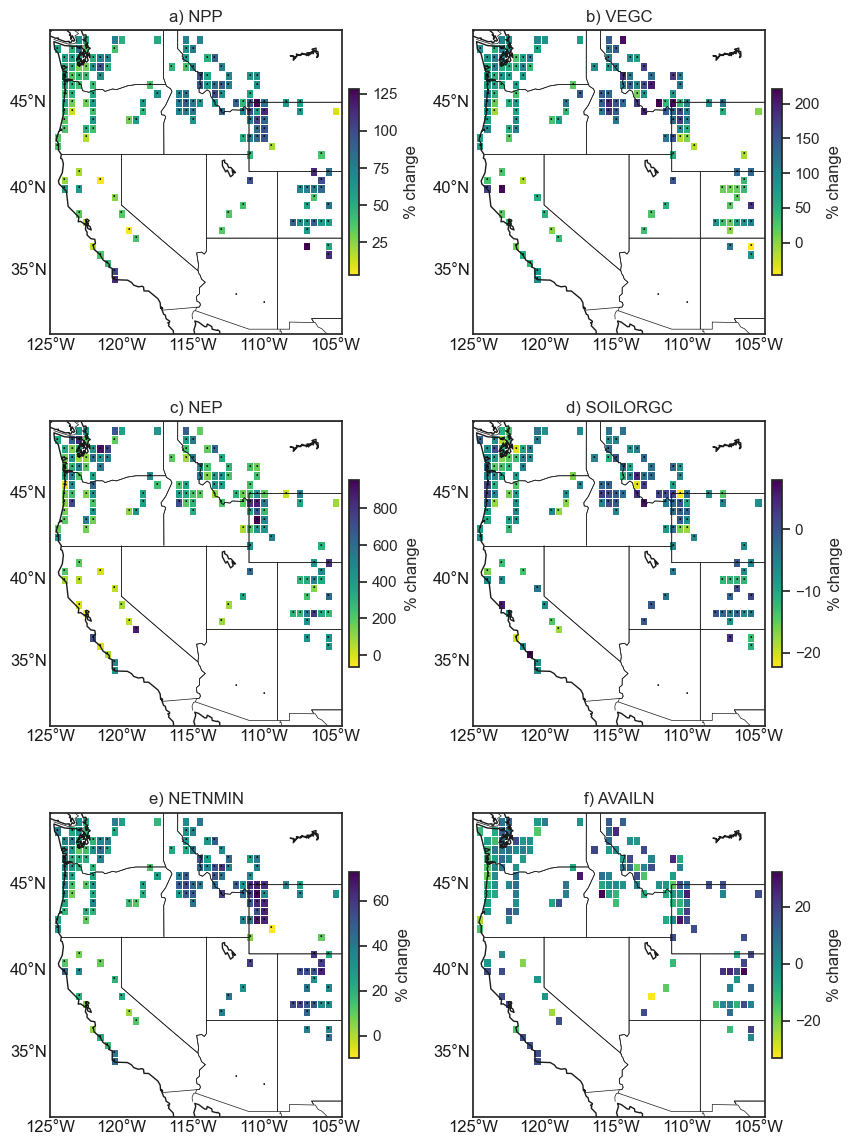

In [10]:
# Plot the data
data_list = [npp_difference,vegc_difference,  nep_difference, soilorgc_difference, netnmin_difference, availn_difference]
subplot_titles = ["a) NPP", "b) VEGC", "c) NEP", "d) SOILORGC", "e) NETNMIN", "f) AVAILN"]

# Create the subplot
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10, 15), sharex=True, sharey=True)

# Iterate over the data to plot
for i, data in enumerate(data_list):
    lons =np.arange(-125, -104.5,0.5)
    lats = np.arange(31,49,0.5)
    
    for lon in lons:
        for lat in lats:
            if not ((data["LON"]==lon)&(data["LAT"]==lat)).any():
                
                data = pd.concat([data, pd.DataFrame({"LON": lon, "LAT": lat, "PERCENT_DIFFERENCE": [-99999], "p_value":[1]})], ignore_index=True)
                
    data =data.sort_values(by=["LON","LAT"])
    
    lon_new, lat_new = np.meshgrid(np.arange(-125, -104.5, 0.5), np.arange(31, 49, 0.5))
    z = griddata((data["LON"], data["LAT"]), data["PERCENT_DIFFERENCE"], (lon_new, lat_new), method="linear")
    
    # Select the axis to plot on
    subplot = ax.flat[i]

    sns.set_theme(style="ticks", font="sans-serif", rc={"lines.linewidth": 2.5})
    m = Basemap(
        projection="mill",
        llcrnrlat=31,
        llcrnrlon=-125,
        urcrnrlat=49,
        urcrnrlon=-104.5,
        resolution="l",
        ax=subplot  # Use the selected axis to plot
    )
    m.drawcoastlines()
    m.drawcountries()
    m.drawstates()
    x, y = m(lon_new, lat_new)

    # set the color of grids with PERCENT_DIFFERENCE == -99999 to white
    z_masked = np.ma.masked_where(z == -99999, z)

    pcm = m.pcolormesh(x, y, z_masked, cmap="viridis_r", edgecolor="white", linewidth=0.5)

    # mark grids with p_value ==1 with black bullet and PERCENT_DIFFERENCE != -99999
    for lati in range(len(lats)-1):
        for loni in range(len(lons)-1):
            if (data[(data.LAT>=lats[lati])&(data.LAT<=lats[lati+1])&\
                    (data.LON>=lons[loni])&(data.LON<=lons[loni+1])].p_value.values[0]==1) & \
                    (data[(data.LAT>=lats[lati])&(data.LAT<=lats[lati+1])&\
                    (data.LON>=lons[loni])&(data.LON<=lons[loni+1])].PERCENT_DIFFERENCE.values[0]!=-99999):
                            plt.text(x[0][loni], y[lati][0], "•", fontsize=5, ha="center", va="center", color="black", transform=subplot.transData)

    # Add colorbar for each plot
    cbar = plt.colorbar(pcm, orientation="vertical", shrink=0.5, pad=0.02)
    cbar.set_label(label="% change", labelpad=5)
    
    # set the intervals for parallels and meridians
    lat_interval = 5
    lon_interval = 5

    # draw parallels and meridians
    parallels = np.arange(25, 50, lat_interval)
    meridians = np.arange(-130, -104.5, lon_interval)
    m.drawparallels(
        parallels, labels=[True, False, False, False], fontsize=12, linewidth=0.001
    )
    m.drawmeridians(
        meridians, labels=[False, False, False, True], fontsize=12, linewidth=0.001
    )

    # Set the title for the subplot
    subplot.set_title(f"{subplot_titles[i]}")

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.05)
plt.savefig("../figures/diff_all.svg", dpi=1200, format="svg",bbox_inches="tight")
# Show the plot
plt.show()

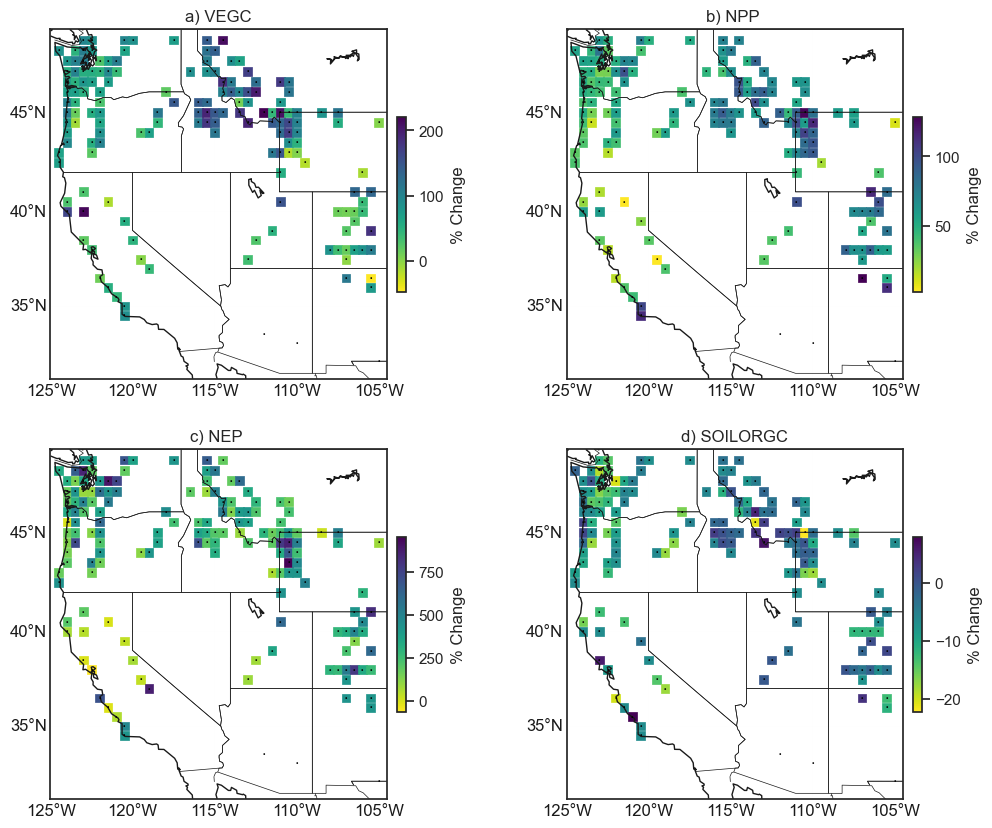

In [6]:
# Subplots with Basemap
# Create a list of data to plot in each subplot
data_list = [vegc_difference, npp_difference, nep_difference, soilorgc_difference]
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(13, 10), sharex=True, sharey=True)
sns.set_theme(style="ticks", font="sans-serif", rc={"lines.linewidth": 2.5})
# Create a Basemap object for each subplot and plot the corresponding data
for i in range(2):
    for j in range(2):
        m = Basemap(
            projection="mill",
            llcrnrlat=31,
            llcrnrlon=-125,
            urcrnrlat=49,
            urcrnrlon=-104.5,
            resolution="l",
            ax=ax[i, j],
        )
        m.drawcoastlines()
        m.drawcountries()
        m.drawstates()

        # Convert the latitude and longitude values in the DataFrame to the map coordinates
        x, y = m(data_list[i * 2 + j]["LON"].values, data_list[i * 2 + j]["LAT"].values)

        # Plot the scatter plot
        sc = m.scatter(
            x,
            y,
            c=data_list[i * 2 + j]["PERCENT_DIFFERENCE"],
            s=40,
            marker="s",
            #edgecolors="white",
            cmap="viridis_r",
            linewidths=0.5,
        )

        # Add a colorbar for each subplot
        cbar = fig.colorbar(
            sc, ax=ax[i, j], orientation="vertical", shrink=0.5, pad=0.02
        )
        cbar.set_label(label="% Change", labelpad=5)

        # Plot significant points
        for index, row in data_list[i * 2 + j].iterrows():
            if row["p_value"] == 1:
                x, y = m(row["LON"], row["LAT"])
                ax[i, j].text(
                    x, y, "•", fontsize=5, ha="center", va="center", color="black"
                )

        lat_interval = 5
        lon_interval = 5
        parallels = np.arange(25, 50, lat_interval)
        meridians = np.arange(-130, -104.5, lon_interval)
        m.drawparallels(
            parallels, labels=[True, False, False, False], fontsize=12, linewidth=0.001
        )
        m.drawmeridians(
            meridians, labels=[False, False, False, True], fontsize=12, linewidth=0.001
        )

        # Add a title for each subplot
        if i == 0 and j == 0:
            ax[i, j].set_title("a) VEGC")
        elif i == 0 and j == 1:
            ax[i, j].set_title("b) NPP ")
        elif i == 1 and j == 0:
            ax[i, j].set_title("c) NEP ")
        elif i == 1 and j == 1:
            ax[i, j].set_title("d) SOILORGC")

plt.subplots_adjust(wspace=0.05)


plt.savefig(
    "../figures/difference_combined." + image_format,
    dpi=1200,
    format=image_format,
    bbox_inches="tight",
)

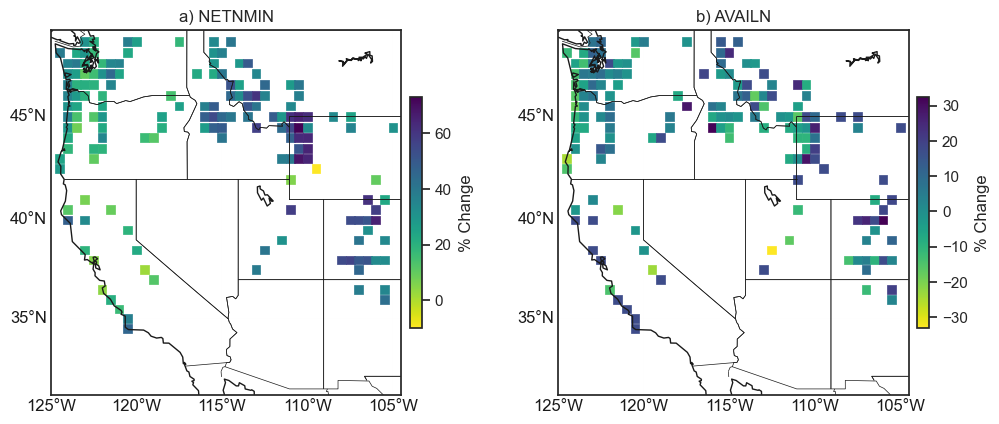

In [7]:
# Plot NETMIN and AVAILN

data_list = [netnmin_difference, availn_difference]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharex=True, sharey=True)

sns.set_theme(style="ticks", font="sans-serif", rc={"lines.linewidth": 2.5})

for i in range(2):
    m = Basemap(
        projection="mill",
        llcrnrlat=31,
        llcrnrlon=-125,
        urcrnrlat=49,
        urcrnrlon=-104.5,
        resolution="l",
        ax=ax[i],
    )
    m.drawcoastlines()
    m.drawcountries()
    m.drawstates()

    x, y = m(data_list[i]["LON"].values, data_list[i]["LAT"].values)

    sc = m.scatter(
        x,
        y,
        c=data_list[i]["PERCENT_DIFFERENCE"],
        s=40,
        marker="s",
        cmap="viridis_r",
        #edgecolors="grey",
        linewidths=0.5,
    )

    cbar = fig.colorbar(sc, ax=ax[i], orientation="vertical", shrink=0.5, pad=0.02)
    cbar.set_label(label="% Change", labelpad=5)
    """
    for index, row in data_list[i].iterrows():
        if row["p_value"] == 1:
            x, y = m(row["LON"], row["LAT"])
            ax[i].text(x, y, "•", fontsize=5, ha="center", va="center", color="black")
    """

    lat_interval = 5
    lon_interval = 5
    parallels = np.arange(25, 50, lat_interval)
    meridians = np.arange(-130, -104.5, lon_interval)
    m.drawparallels(
        parallels, labels=[True, False, False, False], fontsize=12, linewidth=0.001
    )
    m.drawmeridians(
        meridians, labels=[False, False, False, True], fontsize=12, linewidth=0.001
    )

    if i == 0:
        ax[i].set_title("a) NETNMIN")
    else:
        ax[i].set_title("b) AVAILN")

plt.savefig(
    "../figures/difference_combined1." + image_format,
    dpi=1200,
    format=image_format,
    bbox_inches="tight",
)